In [1]:
import os, math, random, time, warnings, contextlib
from torch.amp import GradScaler, autocast
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns 
from functools import lru_cache
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms as T, models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import plotly.express as px

In [2]:
# Config & Paths 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# CSVs and images
IMG_ROOT = "/kaggle/input/eurosat-dataset/EuroSAT"
# NOTE: keep your CSVs where your notebook expects them:
CSV_ROOT = "/kaggle/input/test-train-validation-csvs"

TRAIN_CSV = "train.csv"
VAL_CSV   = "validation.csv"
TEST_CSV  = "test.csv"

# Image & pretrain hyperparams 
IMG_SIZE = 224
BATCH_SIZE_PRETRAIN = 64
EPOCHS_PRETRAIN = 300
LR_PRETRAIN = 3e-4
PROJ_DIM = 128
TEMP = 0.2  

# Linear eval hyperparams 
BATCH_SIZE_LINEAR = 64
EPOCHS_LINEAR = 300
LR_LINEAR = 1e-3
PATIENCE = 10

BATCH_PRE = BATCH_SIZE_PRETRAIN
EPOCHS_PRE = EPOCHS_PRETRAIN
LR_PRE = LR_PRETRAIN

BATCH_LIN = BATCH_SIZE_LINEAR
EPOCHS_LIN = EPOCHS_LINEAR
LR_LIN = LR_LINEAR

print("Device:", DEVICE)
print(f"Device: {DEVICE.type}")
print(f"IMG_ROOT: {IMG_ROOT}")
print(f"CSV_ROOT: {CSV_ROOT}")
print(f"Splits: {TRAIN_CSV} {VAL_CSV} {TEST_CSV}")
print(f"IMG_SIZE={IMG_SIZE}  BATCH_PRE={BATCH_PRE}  EPOCHS_PRE={EPOCHS_PRE}  LR_PRE={LR_PRE}  TEMP={TEMP}")
print(f"BATCH_LIN={BATCH_LIN}  EPOCHS_LIN={EPOCHS_LIN}  LR_LIN={LR_LIN}  PATIENCE={PATIENCE}  PROJ_DIM={PROJ_DIM}")

# Speed knobs (kept from your original)
try:
    torch.backends.cudnn.benchmark = True
except Exception:
    pass
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
except Exception:
    pass

Device: cuda
Device: cuda
IMG_ROOT: /kaggle/input/eurosat-dataset/EuroSAT
CSV_ROOT: /kaggle/input/test-train-validation-csvs
Splits: train.csv validation.csv test.csv
IMG_SIZE=224  BATCH_PRE=64  EPOCHS_PRE=300  LR_PRE=0.0003  TEMP=0.2
BATCH_LIN=64  EPOCHS_LIN=300  LR_LIN=0.001  PATIENCE=10  PROJ_DIM=128


In [3]:
# CSV Loading 

PATH_COL_ENV  = os.environ.get("PATH_COL_NAME", "").strip()
LABEL_COL_ENV = os.environ.get("LABEL_COL_NAME", "").strip()  # not used for final labels (we map by folder)
EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp", ".gif")

def _pick_col(df, candidates):
    lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in df.columns:
            return cand
        if cand.lower() in lower:
            return lower[cand.lower()]
    return None

def _looks_like_filename(s: str) -> bool:
    s = str(s).strip().lower()
    if not s:
        return False
    for ext in EXTS:
        if s.endswith(ext):
            return True
    return False

def _fix_one_path(p, img_root):
    p = str(p).strip()
    if os.path.exists(p):
        return p
    p2 = os.path.join(img_root, p)
    if os.path.exists(p2):
        return p2
    # try removing leading ./ and rejoin
    p3 = p.lstrip("./")
    p3 = os.path.join(img_root, p3)
    return p3  # PIL will raise later if invalid; useful to catch bad rows

def load_split(csv_root, csv_name, img_root):
    csv_path = os.path.join(csv_root, csv_name)
    df = pd.read_csv(csv_path)

    # 1) Choose the image path column (env override → common names → folder+filename → heuristic)
    pcol = PATH_COL_ENV if (PATH_COL_ENV and PATH_COL_ENV in df.columns) else None
    if pcol is None:
        pcol = _pick_col(df, [
            "path","image","filepath","file","img",
            "filename","file_name","image_name","imagepath","image_path",
            "Image","ImageID","img_path"
        ])

    if pcol is None:
        folder_col = _pick_col(df, ["folder","dir","directory","class_dir","parent"])
        file_col   = _pick_col(df, ["filename","file_name","file","image","img","image_name"])
        if folder_col is not None and file_col is not None:
            df["__path__"] = df[folder_col].astype(str).str.rstrip("/\\") + "/" + df[file_col].astype(str).str.lstrip("/\\")
            pcol = "__path__"

    if pcol is None:
        # heuristic: pick a column whose values look like filenames (check up to 50 rows without slicing)
        chosen = None
        total = min(len(df), 50)
        for col in df.columns:
            cnt = 0
            checked = 0
            for val in df[col].astype(str):
                if _looks_like_filename(val):
                    cnt += 1
                checked += 1
                if checked >= total:
                    break
            if checked > 0 and (cnt / float(checked)) >= 0.6:
                chosen = col
                break
        pcol = chosen

    if pcol is None:
        raise ValueError(
            f"Image path column not found in {csv_name}. "
            f"Columns present: {list(df.columns)}. "
            f'If needed, set os.environ["PATH_COL_NAME"]="your_image_column".'
        )

    # Build output with normalized paths
    out = pd.DataFrame()
    out["path"] = df[pcol].astype(str).apply(lambda p: _fix_one_path(p, img_root))

    print(
        f"Loaded {csv_name} — shape={out.shape} | path_col='{pcol}'\n"
        f"Head:\n{out.head(3)}"
    )
    return out

# Read splits
train_df = load_split(CSV_ROOT, TRAIN_CSV, IMG_ROOT)
val_df   = load_split(CSV_ROOT, VAL_CSV,   IMG_ROOT)
test_df  = load_split(CSV_ROOT, TEST_CSV,  IMG_ROOT)

def _class_name_from_path(p):
    return os.path.basename(os.path.dirname(str(p)))

all_names = pd.concat([
    train_df["path"].map(_class_name_from_path),
    val_df["path"].map(_class_name_from_path),
    test_df["path"].map(_class_name_from_path)
], axis=0)

classes = {name: i for i, name in enumerate(sorted(all_names.unique()))}

for df_ in (train_df, val_df, test_df):
    df_["label"] = df_["path"].map(lambda p: classes[_class_name_from_path(p)]).astype(int)

num_classes = len(classes)
print(f"Classes: {num_classes} | Class map example: {dict(list(classes.items())[:5])}")

Loaded train.csv — shape=(18900, 1) | path_col='Filename'
Head:
                                                path
0  /kaggle/input/eurosat-dataset/EuroSAT/AnnualCr...
1  /kaggle/input/eurosat-dataset/EuroSAT/Herbaceo...
2  /kaggle/input/eurosat-dataset/EuroSAT/Permanen...
Loaded validation.csv — shape=(5400, 1) | path_col='Filename'
Head:
                                                path
0  /kaggle/input/eurosat-dataset/EuroSAT/Pasture/...
1  /kaggle/input/eurosat-dataset/EuroSAT/Forest/F...
2  /kaggle/input/eurosat-dataset/EuroSAT/Highway/...
Loaded test.csv — shape=(2700, 1) | path_col='Filename'
Head:
                                                path
0  /kaggle/input/eurosat-dataset/EuroSAT/AnnualCr...
1  /kaggle/input/eurosat-dataset/EuroSAT/Resident...
2  /kaggle/input/eurosat-dataset/EuroSAT/Pasture/...
Classes: 10 | Class map example: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4}


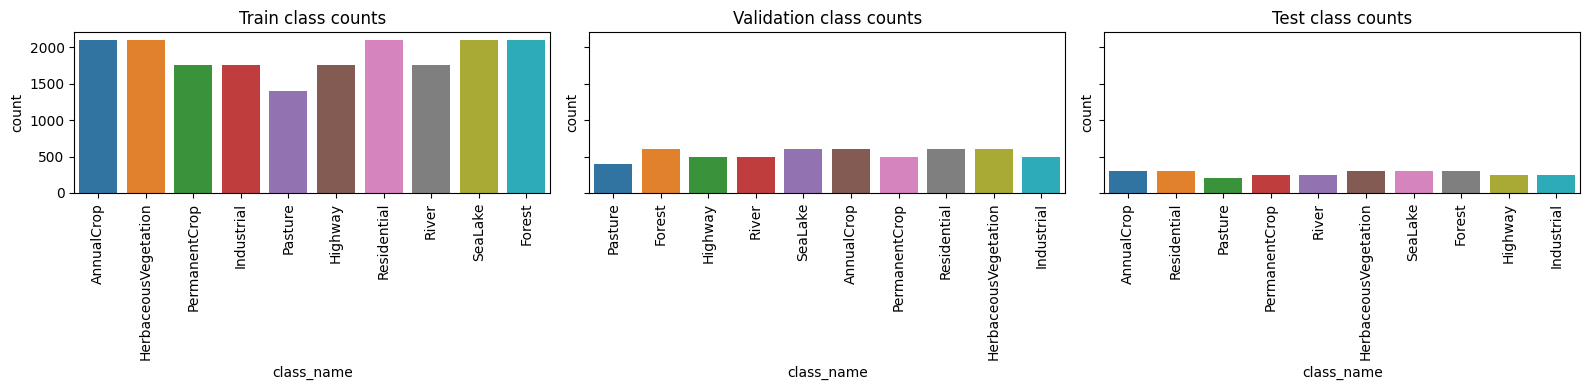

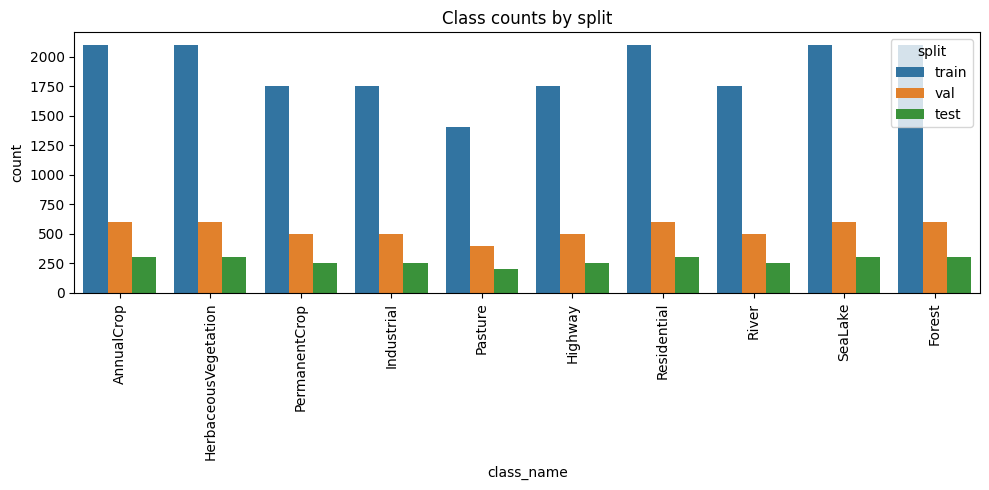

In [4]:
# Count plots: class distribution in train/val/test

# Map numeric labels → class names
id2name = {v:k for k,v in classes.items()}
for df_ in (train_df, val_df, test_df):
    df_["class_name"] = df_["label"].map(id2name)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.countplot(data=train_df, x="class_name", ax=axes[0])
axes[0].set_title("Train class counts"); axes[0].tick_params(axis='x', rotation=90)

sns.countplot(data=val_df, x="class_name", ax=axes[1])
axes[1].set_title("Validation class counts"); axes[1].tick_params(axis='x', rotation=90)

sns.countplot(data=test_df, x="class_name", ax=axes[2])
axes[2].set_title("Test class counts"); axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout(); plt.show()

# (Optional) Combined stacked look by melt + bar (quick view)
train_df["split"]="train"; val_df["split"]="val"; test_df["split"]="test"
all_df = pd.concat([train_df[["class_name","split"]],
                    val_df[["class_name","split"]],
                    test_df[["class_name","split"]]], ignore_index=True)

plt.figure(figsize=(10,5))
sns.countplot(data=all_df, x="class_name", hue="split")
plt.title("Class counts by split"); plt.xticks(rotation=90); plt.tight_layout(); plt.show()

In [5]:
# Datasets & DataLoaders

def auto_workers():
    cpu = os.cpu_count() or 4
    return max(4, min(12, cpu))  # more workers to feed GPU

# SimCLR augmentations (same flavor, cheaper on CPU)
IMG_SIZE = int(IMG_SIZE)  # keep 224
k = 7  # smaller blur kernel

base_aug = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.35, 1.0)),   # fewer extreme resizes than (0.2,1.0)
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.3, 0.3, 0.3, 0.1)], p=0.5),  # lighter & less frequent than p=0.8
    T.RandomGrayscale(p=0.08),                                  # was 0.2
    T.RandomApply([T.GaussianBlur(kernel_size=k, sigma=(0.1, 1.0))], p=0.25),  # not every sample
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

class PairTransform:
    def __init__(self, base_tf): self.base_tf = base_tf
    def __call__(self, img):
        return self.base_tf(img), self.base_tf(img)

train_transform = PairTransform(base_aug)

eval_transform  = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Cache decoded images in RAM (speeds up from epoch 2+)
@lru_cache(maxsize=100000)
def _load_rgb(path: str):
    return Image.open(path).convert("RGB")

class PairDataset(Dataset):
    def __init__(self, df, transform, cache=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.cache = cache
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = _load_rgb(row["path"]) if self.cache else Image.open(row["path"]).convert("RGB")
        x1, x2 = self.transform(img)
        return x1, x2

class ImageDataset(Dataset):
    def __init__(self, df, transform, cache=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.cache = cache
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = _load_rgb(row["path"]) if self.cache else Image.open(row["path"]).convert("RGB")
        x = self.transform(img)
        y = int(row["label"])
        return x, y

COMMON = dict(
    num_workers=auto_workers(),
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

# Pairwise loader for pretext
train_pair_loader = DataLoader(
    PairDataset(train_df, train_transform, cache=True),
    batch_size=BATCH_PRE,
    shuffle=True, drop_last=True,
    **COMMON
)

# val_pair_loader (SimCLR-style pairs for validation)
val_pair_loader = DataLoader(
    PairDataset(val_df, train_transform, cache=True),  
    batch_size=BATCH_PRE,
    shuffle=False, drop_last=False,
    **COMMON
)

# Standard loaders for linear eval / features
train_cls_loader = DataLoader(
    ImageDataset(train_df, eval_transform, cache=True),
    batch_size=BATCH_LIN,
    shuffle=True,
    **COMMON
)
val_cls_loader = DataLoader(
    ImageDataset(val_df, eval_transform, cache=True),
    batch_size=BATCH_LIN,
    shuffle=False,
    **COMMON
)
test_cls_loader = DataLoader(
    ImageDataset(test_df, eval_transform, cache=True),
    batch_size=BATCH_LIN,
    shuffle=False,
    **COMMON
)

In [6]:
# Model: ResNet50 encoder + MLP projection head 
def build_encoder(pretrained=False):
    try:
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet50(weights=weights)
    except AttributeError:
        model = models.resnet50(pretrained=pretrained)
    feat_dim = model.fc.in_features
    model.fc = nn.Identity()
    return model, feat_dim

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=128, hidden=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(inplace=True),
            nn.Linear(hidden, proj_dim)
        )
    def forward(self, x): return self.net(x)

encoder, FEAT_DIM = build_encoder(pretrained=False)
proj_head = ProjectionHead(FEAT_DIM, proj_dim=PROJ_DIM).to(DEVICE)
encoder = encoder.to(DEVICE).to(memory_format=torch.channels_last)

params = list(encoder.parameters()) + list(proj_head.parameters())

In [7]:
# Contrastive Loss (NT-Xent) 

def _l2norm(x, eps=1e-8):
    # no @torch.no_grad() here — keep graph so gradients flow
    return x / (x.norm(p=2, dim=1, keepdim=True) + eps)

def nt_xent(z1, z2, temp=0.2):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    B  = z1.size(0)
    Z  = torch.cat([z1, z2], dim=0)           # [2B, D]
    sim = (Z @ Z.t()) / temp                  # [2B, 2B]
    sim.fill_diagonal_(float('-inf'))         # mask self
    idx = torch.arange(B, device=sim.device)
    pos_idx = torch.cat([idx + B, idx], dim=0)
    pos_sim = sim[torch.arange(2*B, device=sim.device), pos_idx].unsqueeze(1)
    sim.scatter_(1, pos_idx.view(-1,1), float('-inf'))  # mask positives in-place
    logits = torch.cat([pos_sim, sim], dim=1)
    labels = torch.zeros(2*B, dtype=torch.long, device=sim.device)
    return F.cross_entropy(logits, labels)

In [8]:
# Optional torch.compile 
USE_COMPILE = False
if torch.cuda.is_available() and hasattr(torch, "compile"):
    major, _ = torch.cuda.get_device_capability()
    USE_COMPILE = major >= 7
if USE_COMPILE:
    try:
        encoder = torch.compile(encoder)
        proj_head = torch.compile(proj_head)
        print("[compile] enabled")
    except Exception as e:
        print("[compile] disabled:", e)

In [9]:
# AMP (new API)
USE_AMP = (DEVICE.type == "cuda")
scaler  = GradScaler("cuda", enabled=USE_AMP)

def AMP():
    return autocast("cuda", dtype=torch.float16, enabled=USE_AMP)

In [10]:
# Resume Start
os.environ["RESUME_PRETRAIN"] = "1"
CKPT_LOAD_DIR = Path("/kaggle/input/simclr-ckpts")  
LAST_PRE_PATH_LOAD = CKPT_LOAD_DIR / "simclr_pretrain_last.pth"

In [11]:
# Pretraining — setup

warnings.filterwarnings("ignore", message=r".lr_scheduler\.step.*optimizer\.step.")

# knobs
LR = LR_PRE if 'LR_PRE' in globals() else (LR_PRETRAIN if 'LR_PRETRAIN' in globals() else 3e-4)
WARMUP_FRAC = WARMUP_FRAC if 'WARMUP_FRAC' in globals() else 0.10
WEIGHT_DECAY = 1e-4
VAL_EVERY = 2   

# checkpoint paths (load from dataset; save to working dir)
CKPT_LOAD_DIR = Path("/kaggle/input/simclr-ckpts")
LAST_PRE_PATH_LOAD       = str(CKPT_LOAD_DIR / "simclr_pretrain_last.pth")
BEST_PRETRAIN_FULL_LOAD  = str(CKPT_LOAD_DIR / "simclr_pretrain_best_full.pth")

CKPT_SAVE_DIR = Path("/kaggle/working/simclr_ckpts"); CKPT_SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_ENC_PATH            = str(CKPT_SAVE_DIR / "simclr_encoder_best.pth")
BEST_PRETRAIN_FULL_PATH  = str(CKPT_SAVE_DIR / "simclr_pretrain_best_full.pth")
LAST_PRE_PATH_SAVE       = str(CKPT_SAVE_DIR / "simclr_pretrain_last.pth")

# Prefer resuming from the current run's working dir if files exist
CANDIDATE_LOADS = [
    Path(LAST_PRE_PATH_SAVE),         # /kaggle/working/.../simclr_pretrain_last.pth
    Path(BEST_PRETRAIN_FULL_PATH),    # /kaggle/working/.../simclr_pretrain_best_full.pth
    Path(LAST_PRE_PATH_LOAD),         # /kaggle/input/.../simclr_pretrain_last.pth
    Path(BEST_PRETRAIN_FULL_LOAD),    # /kaggle/input/.../simclr_pretrain_best_full.pth
]

RESUME_PRETRAIN = bool(int(os.environ.get("RESUME_PRETRAIN", "0"))) 

# optimizer
opt = optimizer if 'optimizer' in globals() else torch.optim.AdamW(
    list(encoder.parameters()) + list(proj_head.parameters()),
    lr=LR, weight_decay=WEIGHT_DECAY
)

# cosine LR with warmup (per-step)
steps_per_epoch = max(1, len(train_pair_loader))
TOTAL_STEPS  = (EPOCHS_PRE if 'EPOCHS_PRE' in globals() else EPOCHS_PRETRAIN) * steps_per_epoch
WARMUP_STEPS = max(1, int(WARMUP_FRAC * TOTAL_STEPS))
def lr_lambda(step):
    if step < WARMUP_STEPS:
        return (step + 1) / float(WARMUP_STEPS)
    t = (step - WARMUP_STEPS) / max(1, (TOTAL_STEPS - WARMUP_STEPS))
    return 0.5 * (1.0 + math.cos(math.pi * t))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

# Resume
hist = {"epoch": [], "train_loss": [], "val_loss": []}
best_val = float("inf"); start_epoch = 1

def _move_optimizer_to_device(opt, device):
    for st in opt.state.values():
        for k, v in list(st.items()):
            if torch.is_tensor(v):
                st[k] = v.to(device)

if RESUME_PRETRAIN:
    ckpt_path = next((p for p in CANDIDATE_LOADS if p is not None and p.exists()), None)
    if ckpt_path is None:
        print("Resume requested but no checkpoint found. Starting fresh.")
    else:
        print(f"Resuming SimCLR from: {ckpt_path}")
        ck = torch.load(str(ckpt_path), map_location=DEVICE)

        # model + head
        encoder.load_state_dict(ck["encoder"])
        proj_head.load_state_dict(ck["proj_head"])

        # optimizer + scheduler
        opt.load_state_dict(ck["optimizer"])
        _move_optimizer_to_device(opt, DEVICE)
        if "scheduler" in ck and ck["scheduler"] is not None:
            try:
                scheduler.load_state_dict(ck["scheduler"])
            except Exception as e:
                print("Scheduler state load skipped:", e)

        # AMP scaler (if present)
        if "scaler" in ck and ck["scaler"] is not None:
            try:
                scaler.load_state_dict(ck["scaler"])
            except Exception as e:
                print("AMP scaler load skipped:", e)

        # bookkeeping
        hist       = ck.get("hist", hist)
        best_val   = ck.get("best_val", best_val)
        start_epoch = int(ck.get("epoch", 0)) + 1
        print(f"→ start_epoch={start_epoch}")
else:
    print("Starting SimCLR training fresh")

Resuming SimCLR from: /kaggle/input/simclr-ckpts/simclr_pretrain_last.pth
→ start_epoch=101


In [12]:
print("RESUME_PRETRAIN =", RESUME_PRETRAIN)
print("start_epoch     =", start_epoch)
print("best_val        =", best_val)
print("hist_len        =", len(hist.get('epoch', [])))

RESUME_PRETRAIN = True
start_epoch     = 101
best_val        = 1.04966801404953
hist_len        = 100


In [13]:
# (Optional) Cleanup local checkpoints — run only when you want a fresh disk state 

CLEAR_PRETRAIN = bool(int(os.environ.get("CLEAR_PRETRAIN", "0")))

if CLEAR_PRETRAIN:
    # Recompute local working-dir paths here so this cell is self-contained
    CKPT_SAVE_DIR = Path("/kaggle/working/simclr_ckpts")
    LAST_PRE_PATH_SAVE       = CKPT_SAVE_DIR / "simclr_pretrain_last.pth"
    BEST_PRETRAIN_FULL_PATH  = CKPT_SAVE_DIR / "simclr_pretrain_best_full.pth"
    BEST_ENC_PATH            = CKPT_SAVE_DIR / "simclr_encoder_best.pth"

    for p in [LAST_PRE_PATH_SAVE, BEST_PRETRAIN_FULL_PATH, BEST_ENC_PATH]:
        try:
            p.unlink()
            print(f"Deleted: {p}")
        except FileNotFoundError:
            pass
        except PermissionError:
            print(f"Cannot delete (read-only?): {p}")

    # If you're clearing, start fresh (no resume)
    os.environ["RESUME_PRETRAIN"] = "0"
else:
    print("Cleanup skipped (CLEAR_PRETRAIN=0).")

Cleanup skipped (CLEAR_PRETRAIN=0).


In [14]:
def run_epoch_pair(loader, train=True):
    total, n = 0.0, 0
    encoder.train() if train else encoder.eval()
    proj_head.train() if train else proj_head.eval()

    for x1, x2 in loader:
        x1 = x1.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)
        x2 = x2.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)

        if train:
            opt.zero_grad(set_to_none=True)
            with AMP():
                z1 = encoder(x1); z2 = encoder(x2)
                loss = nt_xent(proj_head(z1), proj_head(z2), temp=TEMP)
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                loss.backward(); opt.step()
            scheduler.step()
        else:
            with torch.no_grad():
                with AMP():
                    z1 = encoder(x1); z2 = encoder(x2)
                    loss = nt_xent(proj_head(z1), proj_head(z2), temp=TEMP)

        bs = x1.size(0)
        total += float(loss.item()) * bs
        n += bs

    return total / max(1, n)

In [15]:
# Pretraining — training loop

EPOCHS = EPOCHS_PRE if 'EPOCHS_PRE' in globals() else EPOCHS_PRETRAIN

for epoch in range(start_epoch, EPOCHS + 1):
    t0 = time.time()
    train_loss = run_epoch_pair(train_pair_loader, train=True)

    do_val = (VAL_EVERY > 0) and (epoch % VAL_EVERY == 0) and (val_pair_loader is not None) and (len(val_pair_loader) > 0)
    val_loss = run_epoch_pair(val_pair_loader, train=False) if do_val else float("nan")

    hist["epoch"].append(epoch); hist["train_loss"].append(train_loss); hist["val_loss"].append(val_loss)

    cur_lr = float(opt.param_groups[0]["lr"])
    print(f"[epoch {epoch:02d}] train_loss={train_loss:.4f} "
          f"val_loss={val_loss:.4f} lr={cur_lr:.8f} "
          f"({time.time() - t0:.1f}s)")

# Save BEST (only when val ran)
if not math.isnan(val_loss) and val_loss < best_val - 1e-6:
    best_val = val_loss
    torch.save({"encoder": encoder.state_dict()}, BEST_ENC_PATH)

    torch.save(
        {
            "encoder": encoder.state_dict(),
            "proj_head": proj_head.state_dict(),
            "optimizer": opt.state_dict(),
            "scheduler": scheduler.state_dict(),
            "scaler": scaler.state_dict() if scaler is not None else None,
            "hist": hist,
            "epoch": epoch,
            "best_val": best_val,
        },
        BEST_PRETRAIN_FULL_PATH
    )
    print(f" Saved BEST (epoch={epoch})")

# Save LAST every epoch
torch.save(
    {
        "encoder": encoder.state_dict(),
        "proj_head": proj_head.state_dict(),
        "optimizer": opt.state_dict(),
        "scheduler": scheduler.state_dict(),
        "scaler": scaler.state_dict() if scaler is not None else None,
        "hist": hist,
        "epoch": epoch,
        "best_val": best_val,
    },
    LAST_PRE_PATH_SAVE
)

[epoch 101] train_loss=1.0309 val_loss=nan lr=0.00025166 (200.2s)
[epoch 102] train_loss=1.0248 val_loss=1.1573 lr=0.00025037 (237.0s)
[epoch 103] train_loss=1.0262 val_loss=nan lr=0.00024907 (185.3s)
[epoch 104] train_loss=1.0215 val_loss=1.1630 lr=0.00024775 (217.4s)
[epoch 105] train_loss=1.0223 val_loss=nan lr=0.00024642 (184.6s)
[epoch 106] train_loss=1.0178 val_loss=1.1435 lr=0.00024507 (217.7s)
[epoch 107] train_loss=1.0145 val_loss=nan lr=0.00024372 (185.2s)
[epoch 108] train_loss=1.0140 val_loss=1.1522 lr=0.00024235 (217.4s)
[epoch 109] train_loss=1.0074 val_loss=nan lr=0.00024097 (184.9s)
[epoch 110] train_loss=1.0042 val_loss=1.1220 lr=0.00023957 (217.2s)
[epoch 111] train_loss=1.0054 val_loss=nan lr=0.00023817 (185.0s)
[epoch 112] train_loss=1.0032 val_loss=1.1383 lr=0.00023675 (218.6s)
[epoch 113] train_loss=0.9995 val_loss=nan lr=0.00023532 (185.0s)
[epoch 114] train_loss=0.9921 val_loss=1.1164 lr=0.00023388 (218.3s)
[epoch 115] train_loss=0.9924 val_loss=nan lr=0.0002324

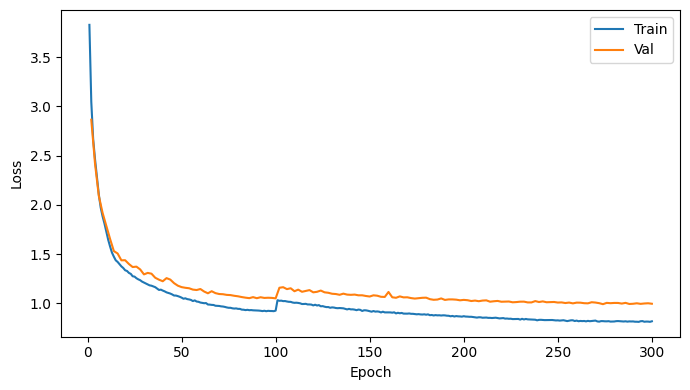

In [16]:
# Pretext loss 
ep = np.array(hist["epoch"], dtype=int)
tr = np.array(hist["train_loss"], dtype=float)
va = np.array(hist["val_loss"], dtype=float)

plt.figure(figsize=(7,4))
plt.plot(ep, tr, label="Train")
m = np.isfinite(va)
if m.any():
    plt.plot(ep[m], va[m], label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
plt.show()

In [17]:
# Linear Evaluation (clean)

BEST_ENC_PATH = Path(BEST_ENC_PATH) if not isinstance(BEST_ENC_PATH, Path) else BEST_ENC_PATH
BEST_CLS_PATH = Path(CKPT_SAVE_DIR) / "linear_cls_best.pth"  # save best linear head here

# -- Load best pretrained encoder (encoder-only) --
if BEST_ENC_PATH.exists():
    ck = torch.load(str(BEST_ENC_PATH), map_location=DEVICE)
    # allow either {"encoder": state_dict} or raw state_dict
    encoder.load_state_dict(ck["encoder"] if isinstance(ck, dict) and "encoder" in ck else ck)
    print(f"[info] Loaded encoder weights from {BEST_ENC_PATH.name}")
else:
    print(f"[warn] {BEST_ENC_PATH} not found; using current encoder in memory.")

# -- Freeze encoder (no gradients during linear eval) --
encoder.eval()
for p in encoder.parameters():
    p.requires_grad = False

# -- Linear classifier and optimizer (only classifier trains) --
classifier = nn.Linear(FEAT_DIM, num_classes).to(DEVICE)
opt_lin = torch.optim.AdamW(classifier.parameters(), lr=LR_LIN, weight_decay=1e-4)

# -- Eval helper: average CE loss + accuracy --
@torch.no_grad()
def eval_loss_acc(loader):
    encoder.eval(); classifier.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        feats  = encoder(x)               # frozen encoder
        logits = classifier(feats)
        total_loss += F.cross_entropy(logits, y, reduction="sum").item()
        correct    += (logits.argmax(1) == y).sum().item()
        total      += y.numel()
    return (total_loss / max(1, total)), (correct / max(1, total))

# -- Train loop (encoder frozen; grads flow only through classifier) --
lin_hist = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc, best_epoch, no_improve = 0.0, 0, 0

for epoch in range(1, EPOCHS_LIN + 1):
    encoder.eval(); classifier.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for x, y in train_cls_loader:
        x = x.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(DEVICE, non_blocking=True)

        opt_lin.zero_grad(set_to_none=True)
        # AMP for CUDA; encoder stays grad-free
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=torch.cuda.is_available()):
            with torch.no_grad():
                feats = encoder(x)        # truly frozen encoder
            logits = classifier(feats)
            loss   = F.cross_entropy(logits, y)

        loss.backward()
        opt_lin.step()

        running_loss += loss.item() * y.size(0)
        correct_train += (logits.argmax(1) == y).sum().item()
        total_train   += y.numel()

    # epoch metrics
    train_loss = running_loss / max(1, total_train)
    train_acc  = correct_train / max(1, total_train)
    val_loss, val_acc = eval_loss_acc(val_cls_loader)

    # log (store acc in % if you like for plotting)
    lin_hist["epoch"].append(epoch)
    lin_hist["train_loss"].append(train_loss)
    lin_hist["val_loss"].append(val_loss)
    lin_hist["train_acc"].append(train_acc * 100.0)
    lin_hist["val_acc"].append(val_acc * 100.0)

    print(f"[Linear {epoch:02d}] train: loss={train_loss:.4f}, acc={train_acc*100:.2f}% | "
          f"val: loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    # early stopping on best val acc
    if val_acc > best_val_acc + 1e-6:
        best_val_acc, best_epoch, no_improve = val_acc, epoch, 0
        torch.save(
            {"state_dict": classifier.state_dict(), "val_acc": best_val_acc, "epoch": best_epoch},
            str(BEST_CLS_PATH)
        )
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stop (patience reached).")
            break

print(f"Best Val Acc: {best_val_acc*100:.2f}% at epoch {best_epoch}")

[info] Loaded encoder weights from simclr_encoder_best.pth
[Linear 01] train: loss=0.2000, acc=93.87% | val: loss=0.1570, acc=94.52%
[Linear 02] train: loss=0.1421, acc=95.28% | val: loss=0.1466, acc=95.28%
[Linear 03] train: loss=0.1300, acc=95.49% | val: loss=0.1457, acc=95.06%
[Linear 04] train: loss=0.1189, acc=95.90% | val: loss=0.1408, acc=95.54%
[Linear 05] train: loss=0.1143, acc=96.03% | val: loss=0.1275, acc=96.11%
[Linear 06] train: loss=0.1066, acc=96.43% | val: loss=0.1350, acc=95.78%
[Linear 07] train: loss=0.1039, acc=96.46% | val: loss=0.1464, acc=95.43%
[Linear 08] train: loss=0.0979, acc=96.60% | val: loss=0.1452, acc=95.46%
[Linear 09] train: loss=0.0961, acc=96.72% | val: loss=0.1261, acc=96.30%
[Linear 10] train: loss=0.0896, acc=96.97% | val: loss=0.1452, acc=95.70%
[Linear 11] train: loss=0.0915, acc=96.87% | val: loss=0.1460, acc=95.46%
[Linear 12] train: loss=0.0868, acc=97.10% | val: loss=0.1319, acc=95.94%
[Linear 13] train: loss=0.0800, acc=97.13% | val: los

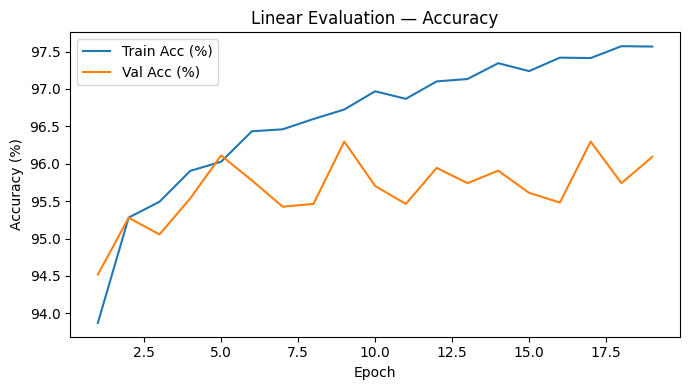

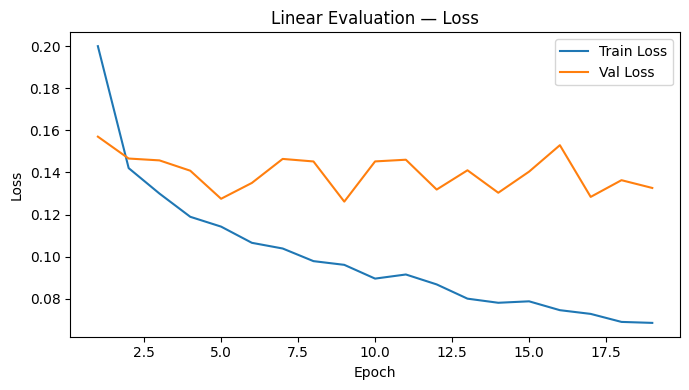

In [18]:
# Plots: Accuracy , Loss

plt.figure(figsize=(7,4))
plt.plot(lin_hist["epoch"], lin_hist["train_acc"], label="Train Acc (%)")
plt.plot(lin_hist["epoch"], lin_hist["val_acc"],   label="Val Acc (%)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Linear Evaluation — Accuracy")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(lin_hist["epoch"], lin_hist["train_loss"], label="Train Loss")
plt.plot(lin_hist["epoch"], lin_hist["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Linear Evaluation — Loss")
plt.legend(); plt.tight_layout(); plt.show()


In [19]:
# Test Accuracy + Classification Report

# Load best linear head 
if BEST_CLS_PATH.exists():
    ck_cls = torch.load(str(BEST_CLS_PATH), map_location=DEVICE)
    classifier.load_state_dict(ck_cls["state_dict"])

encoder.eval(); classifier.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_cls_loader:
        imgs   = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        logits = classifier(encoder(imgs))
        preds  = logits.argmax(1)
        y_true.append(labels.cpu()); y_pred.append(preds.cpu())

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()
test_acc = (y_true == y_pred).mean() * 100.0
print(f"Final Test Accuracy: {test_acc:.2f}%")

# Pretty names from your earlier mapping
id2name = {v: k for k, v in classes.items()}
target_names = [id2name[i] for i in range(len(id2name))]
print("\nClassification Report (Test):")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

Final Test Accuracy: 96.26%

Classification Report (Test):
                      precision    recall  f1-score   support

          AnnualCrop      0.976     0.950     0.963       300
              Forest      0.987     0.987     0.987       300
HerbaceousVegetation      0.922     0.950     0.936       300
             Highway      0.915     0.952     0.933       250
          Industrial      0.992     0.956     0.974       250
             Pasture      0.950     0.945     0.947       200
       PermanentCrop      0.946     0.912     0.929       250
         Residential      0.990     0.997     0.993       300
               River      0.945     0.964     0.954       250
             SeaLake      0.993     0.997     0.995       300

            accuracy                          0.963      2700
           macro avg      0.962     0.961     0.961      2700
        weighted avg      0.963     0.963     0.963      2700



In [20]:
# t-SNE utilities 

@torch.no_grad()
def extract_features(encoder, loader, device):
    encoder.eval()
    feats, labels = [], []
    for imgs, y in loader:
        imgs = imgs.to(device, non_blocking=True)
        out = encoder(imgs)
        if isinstance(out, (list, tuple)): out = out[0]
        feats.append(out.detach().cpu())
        labels.append(torch.as_tensor(y).detach().cpu())
    X = torch.cat(feats).numpy()
    y = torch.cat(labels).numpy()
    return X, y

def tsne_plot_3d(X, y, title, save_html=None, n_samples=2000):
    # sample for responsiveness
    if X.shape[0] > n_samples:
        idx = np.random.RandomState(42).choice(X.shape[0], n_samples, replace=False)
        X, y = X[idx], y[idx]
    # auto perplexity in a safe range
    perplexity = min(30, max(5, (int(X.shape[0]) - 1)//4))
    X_emb = TSNE(n_components=3, perplexity=perplexity, init="pca",
                 random_state=42, learning_rate="auto").fit_transform(X)
    fig = px.scatter_3d(x=X_emb[:,0], y=X_emb[:,1], z=X_emb[:,2],
                        color=y.astype(str), title=title, labels={"color":"label"})
    if save_html:
        fig.write_html(save_html)
        print(f"[t-SNE] saved -> {save_html}")
    fig.show()
    return fig

In [21]:
# Silhouette helper (cosine) 

def silhouette_cosine_from_embeddings(X, y, max_n=2000):
 
    # Convert to arrays
    X = np.asarray(X)
    y = np.asarray(y)

    # Need at least 2 classes and ≥2 samples/class
    uniq, counts = np.unique(y, return_counts=True)
    if len(uniq) < 2 or counts.min() < 2:
        return None  # not computable

    # L2-normalize for cosine distance
    X = normalize(X, norm="l2", axis=1)


    # Compute silhouette with cosine distance
    try:
        score = silhouette_score(X, y, metric="cosine")
        return float(score)
    except Exception:
        return None

# TRAIN  
X_tr, y_tr = extract_features(encoder, train_cls_loader, DEVICE)
s_tr = silhouette_cosine_from_embeddings(X_tr, y_tr, max_n=2000)
title_tr = f"3D t-SNE (Train) — Silhouette(cos): {s_tr:.3f}" if s_tr is not None else "3D t-SNE (Train) — Silhouette: N/A"
_ = tsne_plot_3d(X_tr, y_tr, title_tr, save_html="/kaggle/working/tsne3d_train.html")
print(f"Train silhouette (cosine): {s_tr:.3f}" if s_tr is not None else "Train silhouette: N/A")


# TEST
X_te, y_te = extract_features(encoder, test_cls_loader, DEVICE)
s_te = silhouette_cosine_from_embeddings(X_te, y_te, max_n=2000)
title_te = f"3D t-SNE (Test) — Silhouette(cos): {s_te:.3f}" if s_te is not None else "3D t-SNE (Test) — Silhouette: N/A"
_ = tsne_plot_3d(X_te, y_te, title_te, save_html="/kaggle/working/tsne3d_test.html")
print(f"Test silhouette (cosine): {s_te:.3f}" if s_te is not None else "Test silhouette: N/A")

# =========================
# ======== (OPTIONAL) =====
# =========  VAL ==========
# =========================
# Uncomment if you also want validation
# X_val, y_val = extract_features(encoder, val_cls_loader, DEVICE)
# s_val = silhouette_cosine_from_embeddings(X_val, y_val, max_n=2000)
# title_val = f"3D t-SNE (Val) — Silhouette(cos): {s_val:.3f}" if s_val is not None else "3D t-SNE (Val) — Silhouette: N/A"
# _ = tsne_plot_3d(X_val, y_val, title_val, save_html="/kaggle/working/tsne3d_val.html")
# print(f"Val silhouette (cosine): {s_val:.3f}" if s_val is not None else "Val silhouette: N/A")

[t-SNE] saved -> /kaggle/working/tsne3d_train.html


Train silhouette (cosine): 0.242
[t-SNE] saved -> /kaggle/working/tsne3d_test.html


Test silhouette (cosine): 0.261
